2024-01-27 21:24:46.740879: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 21:24:46.742225: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 21:24:46.762476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 21:24:46.762491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 21:24:46.763030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

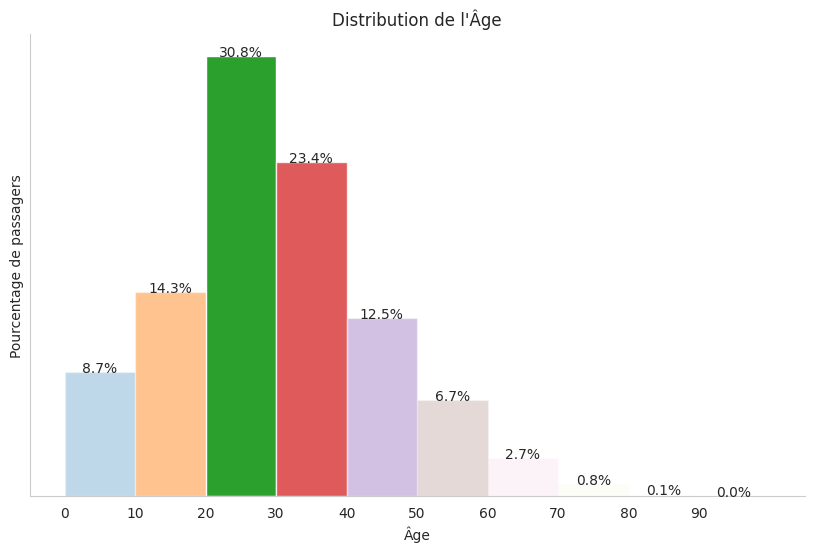

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


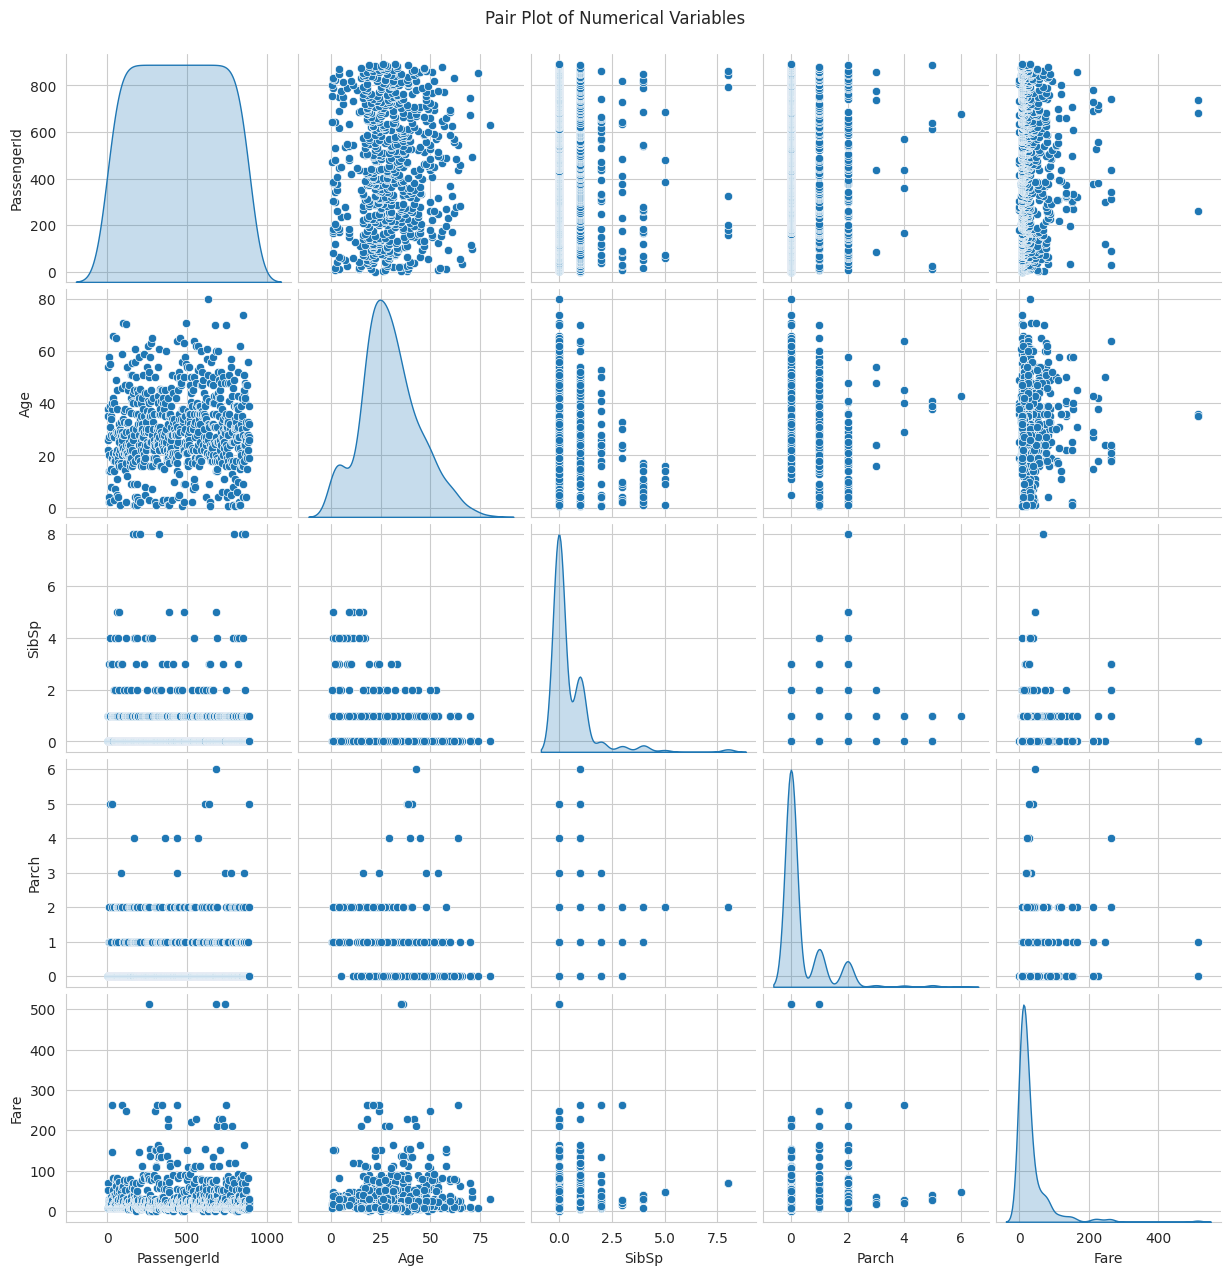

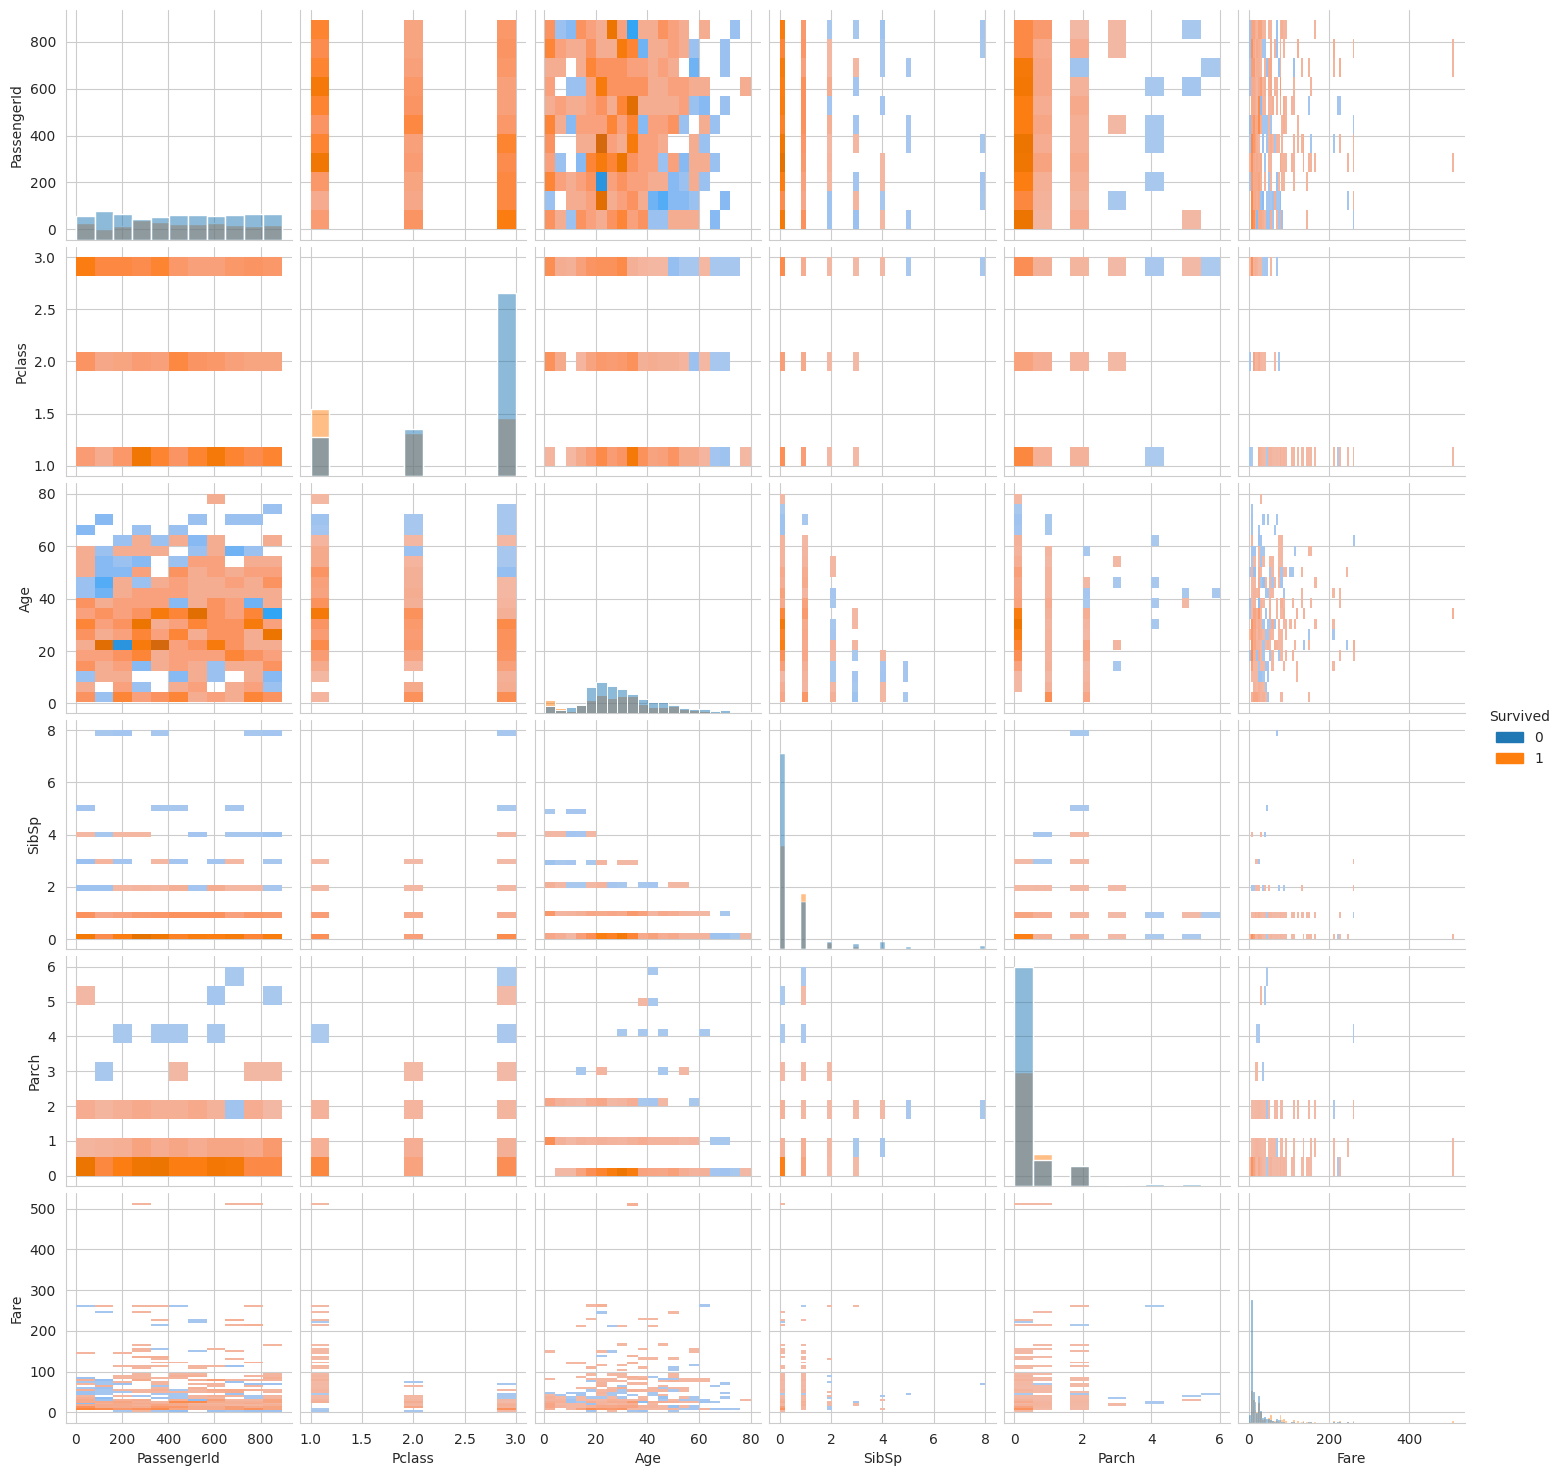

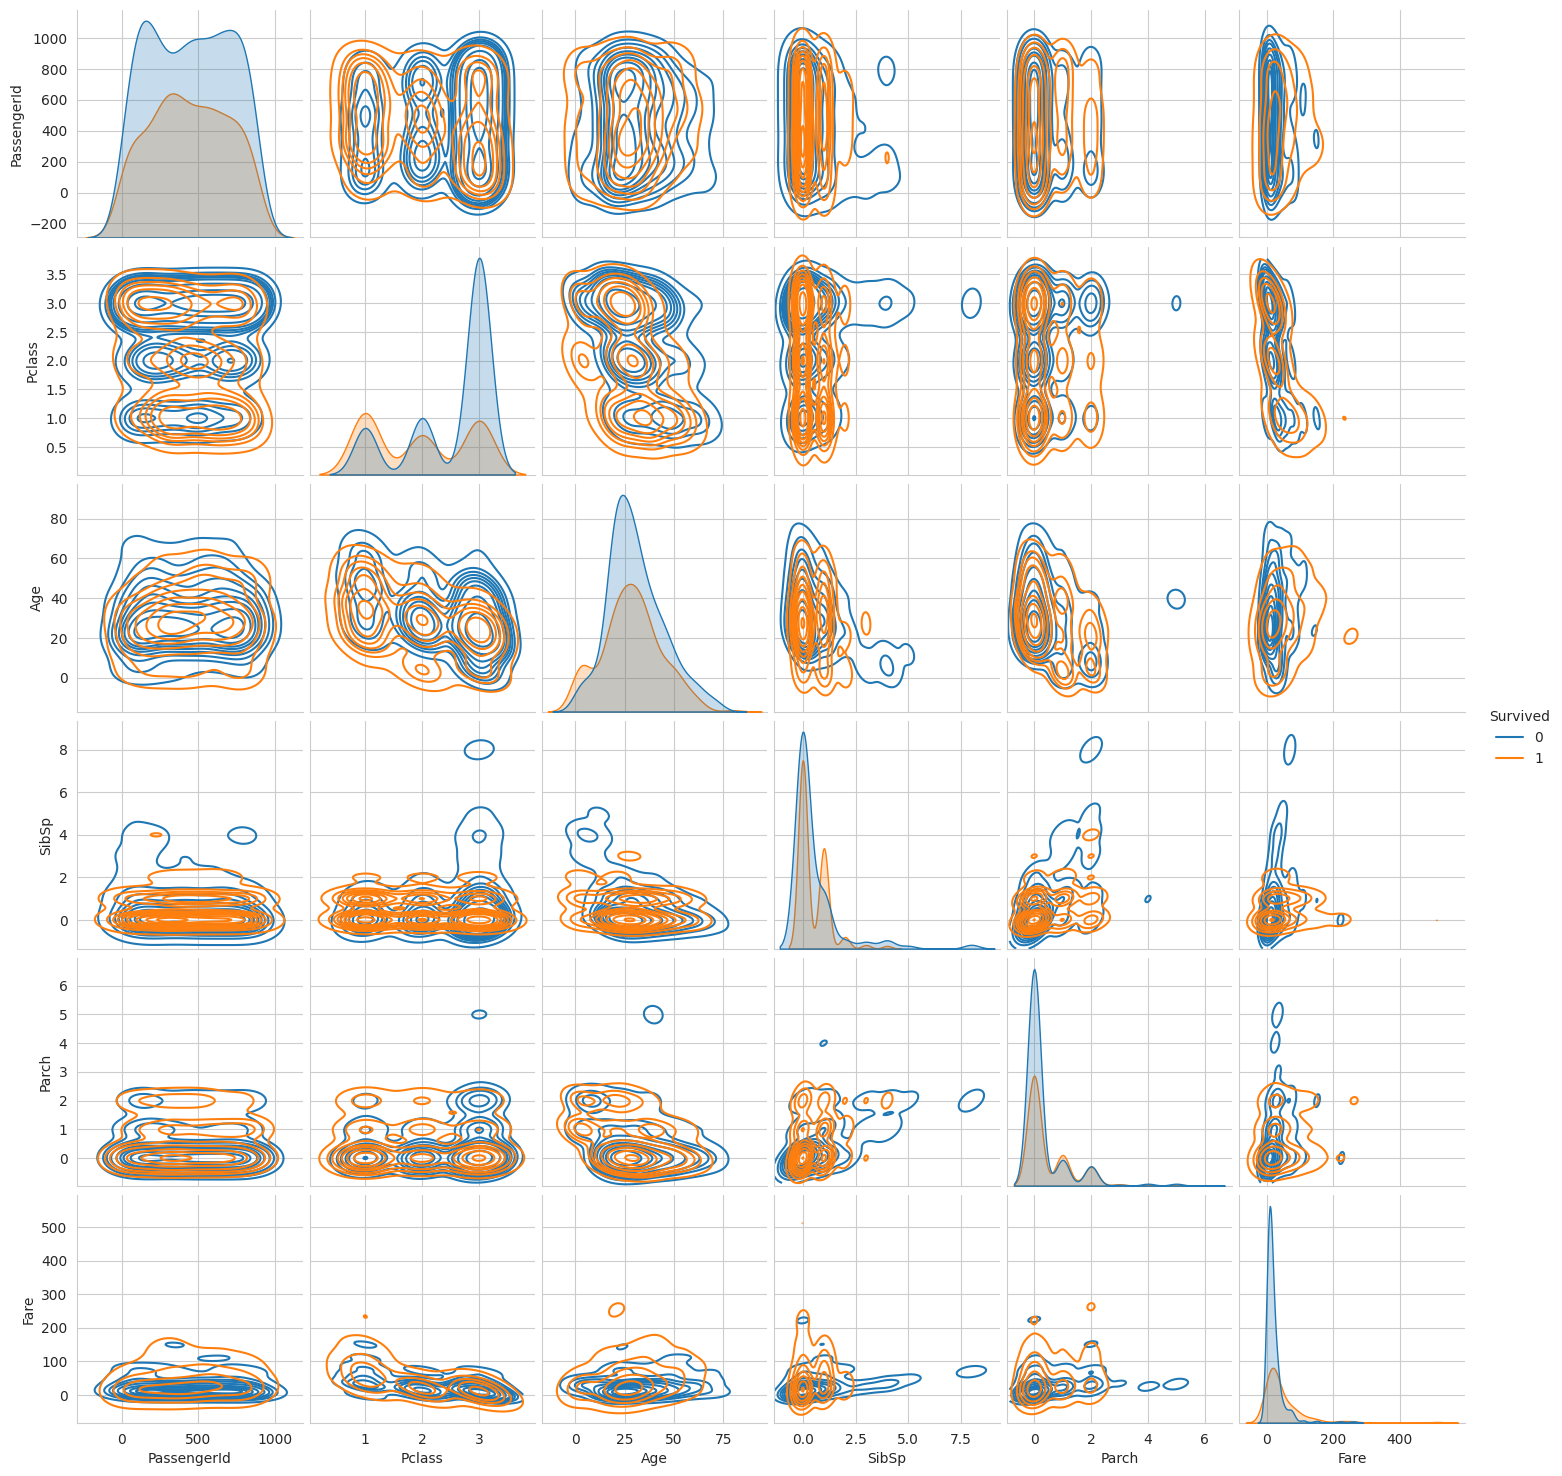

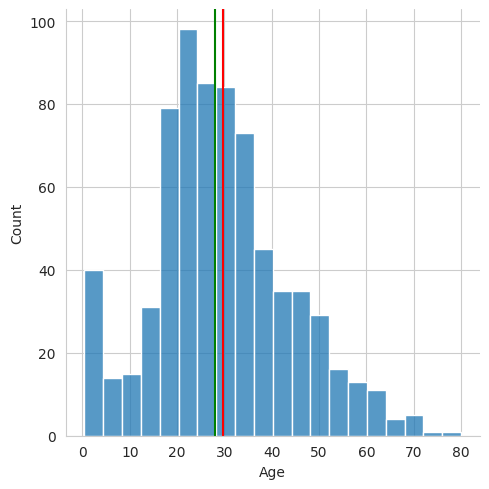

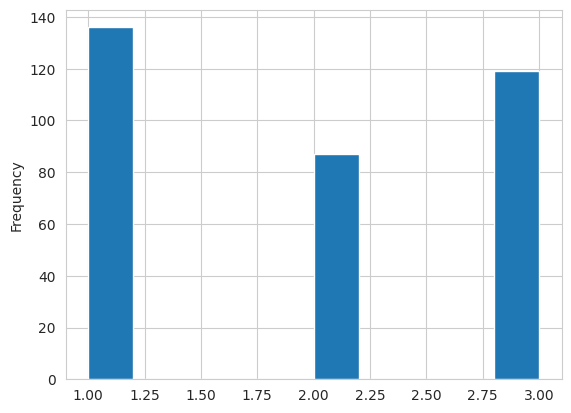

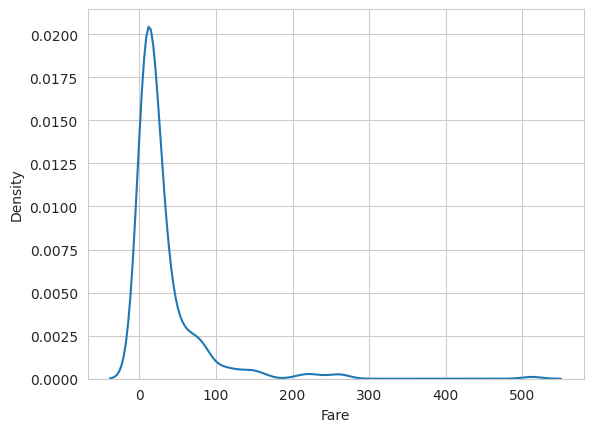

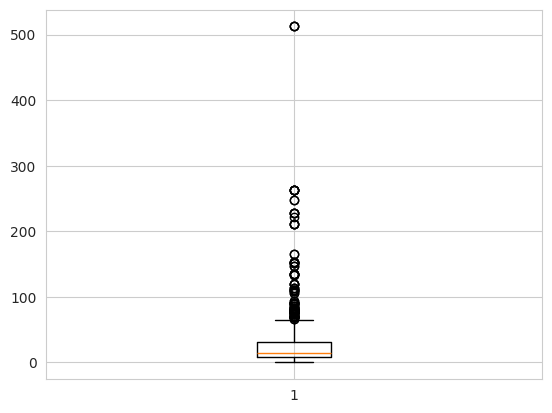

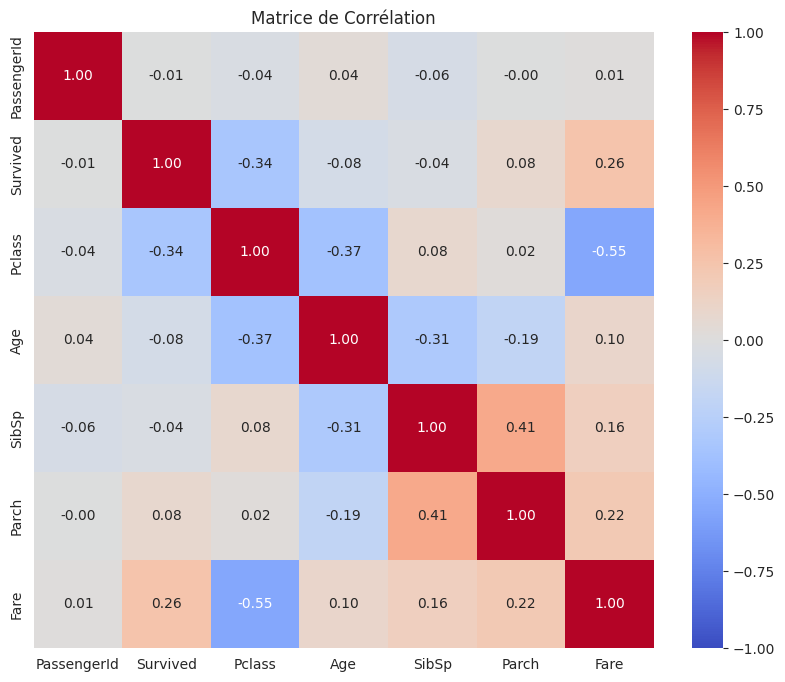

2024-01-27 21:25:07.238447: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-27 21:25:07.238463: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: carolus
2024-01-27 21:25:07.238466: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: carolus
2024-01-27 21:25:07.238546: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.154.5
2024-01-27 21:25:07.238553: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-01-27 21:25:07.238555: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.154.5


In [1]:
# pretraitement des données -> V1 PRETRAITEMENT 
preprocessing_script_path = '/home/charlemagne/workspace/kaggle_challenge_titanic/dev/pre_processing/1_preprocessing_and_dataviz.ipynb'
%run $preprocessing_script_path

In [2]:
def prediction_to_kaggle_format(model, threshold=0.5):
    proba_survive = model.predict(serving_ds, verbose=0)[:, 0]
    return pd.DataFrame({
        "PassengerId": preprocessed_test_df["PassengerId"],
        "Survived": (proba_survive >= threshold).astype(int)
    })

In [3]:
num_trees = 300
min_examples = 5
categorical_algorithm = "CART"

model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0,
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True,
    random_seed=1234,
    num_trees=num_trees,
    min_examples=min_examples,
    categorical_algorithm=categorical_algorithm
)
model.fit(train_ds)

[WARNING 24-01-27 21:25:07.3486 CET gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-27 21:25:07.3489 CET gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-27 21:25:07.3489 CET gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-01-27 21:25:09.4236 CET kernel.cc:1233] Loading model from path /tmp/tmpes6xcnox/model/ with prefix 6f259373a64f421f
[INFO 24-01-27 21:25:09.4249 CET quick_scorer_extended.cc:903] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-01-27 21:25:09.4250 CET abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-01-27 21:25:09.4250 CET kernel.cc:1061] Use fast generic engine


In [4]:
self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

Accuracy: 0.8260869383811951 Loss:0.8608942627906799


In [5]:
kaggle_predictions = prediction_to_kaggle_format(model)
kaggle_predictions.to_csv(submission_file_path, index=False)
print(f"Submission exported to {submission_file_path}")

Submission exported to /home/charlemagne/workspace/kaggle_challenge_titanic/submission/last_submission.csv


In [6]:
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

In [7]:
local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

In [8]:
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])

tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization", ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=0)

Use /tmp/tmp41e_s5tq as temporary training directory


[WARNING 24-01-27 21:25:09.9206 CET gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-27 21:25:09.9206 CET gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-01-27 21:25:09.9206 CET gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-01-27 21:25:21.6911 CET kernel.cc:1233] Loading model from path /tmp/tmp41e_s5tq/model/ with prefix 83692ef6c1bb4969
[INFO 24-01-27 21:25:21.6960 CET decision_forest.cc:660] Model loaded with 30 root(s), 2236 node(s), and 12 input feature(s).
[INFO 24-01-27 21:25:21.6960 CET abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-01-27 21:25:21.6960 CET kernel.cc:1061] Use fast generic engine


In [9]:
tuned_self_evaluation = tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")

Accuracy: 0.8630136847496033 Loss:0.6749962568283081
